# Get word embeddings using Word2Vec

Credits: https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92#702d

In [1]:
import pandas as pd
import numpy as np
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
from gensim.models import Word2Vec
import gensim

In [3]:
#df = pd.DataFrame(pd.read_pickle('df_tokenized'))
df = pd.DataFrame(pd.read_pickle('df_add_feat'))
#target
y=pd.cut(df.Rank,bins=[0,50,100],labels=[1,0])
#features
df_text=df['lyrics_clean']
df_text.head()

0    sam the sham miscellaneous wooly bully wooly b...
1    sugar pie honey bunch you know that i love you...
3    when i woke up this morning you were on my min...
4    you never close your eyes anymore when i kiss ...
5    when you re alone and life is making you lonel...
Name: lyrics_clean, dtype: object

In [4]:
## split dataset
#X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.33, random_state=42)

In [5]:
#preprocessing - gensim requires list of list representation
corpus=df_text
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)


In [6]:
#train gensim word2vec model
model = Word2Vec(lst_corpus,vector_size=300,window=8, min_count=1, sg=1)

In [7]:
print("size of word vector: ", len(model.wv['love']))

size of word vector:  300


In [8]:
model.wv.similarity('love', 'like')

0.22790991

In [9]:
model.wv.similarity('love', 'hate')

0.29659894

In [10]:
model.wv.most_similar('love')

[('unfurl', 0.6157669425010681),
 ('conquer', 0.6099445819854736),
 ('forsake', 0.6015743017196655),
 ('sensitive', 0.5989111065864563),
 ('pleading', 0.5975530743598938),
 ('alfie', 0.5951045751571655),
 ('creamy', 0.5926474928855896),
 ('madly', 0.5918564796447754),
 ('youthful', 0.591113805770874),
 ('perish', 0.5890753865242004)]

In [11]:
#get set of all tokens
tokens = []
for string in df_text:
    lst_words = string.split()
    for word in lst_words:
        tokens.append(word)

set_tokens=set(tokens)

In [12]:
#no of unique words
len(set_tokens)

18632

In [13]:
#cosine similarity
from numpy.linalg import norm
def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model.wv[word]
    for item in target_list :
        if item != word :
            b = model.wv[item]
            cos_sim = np.dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descending order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]

In [14]:
cosine_distance(model,'love',set_tokens,5)

[('unfurl', 0.6157669),
 ('conquer', 0.60994464),
 ('forsake', 0.6015743),
 ('sensitive', 0.59891117),
 ('pleading', 0.5975531)]

## Embedding matrix

The embedding matrix has the following dimensions: number of columns equal to the number of the embedding dimension (here:300) x number of unique words. Matrix of word embeddings will be used as a weight matrix in the neural network classifier.

In [15]:
#use word vectors as features
def get_word_vectors(model, set_tokens):
    wv=[]
    for token in set_tokens:
        wv.append(model.wv[token])

    wv=pd.DataFrame(wv, index=list(set_tokens))
    
    return wv
        
df_wv=get_word_vectors(model,set_tokens)


In [16]:
df_wv.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
seaton,-0.047000,0.026373,0.058923,-0.044333,0.035846,-0.088449,0.021019,0.107275,0.032263,-0.065926,...,-0.032673,0.108863,0.002687,-0.008151,-0.077914,0.012440,-0.012574,-0.012294,-0.022037,0.071189
criteria,-0.048593,0.076605,0.082853,-0.088455,0.065296,-0.097750,0.049689,0.190013,0.043216,-0.093995,...,-0.035724,0.141622,-0.006257,0.010841,-0.107927,0.019987,-0.010355,0.015371,-0.024396,0.100468
schoolboys,-0.065719,0.034370,0.061141,-0.077603,0.064510,-0.123637,0.028787,0.169124,0.007460,-0.083901,...,-0.040172,0.095251,-0.011905,0.024356,-0.103902,0.028844,-0.007555,0.007406,-0.030136,0.072647
impaled,-0.047955,0.002949,0.048360,-0.029128,0.021768,-0.080835,0.006199,0.134822,0.015281,-0.068371,...,-0.018407,0.097432,-0.003606,0.013685,-0.086630,0.024717,-0.003277,-0.002802,-0.028988,0.067788
obi,-0.226381,0.103059,0.037034,0.050004,-0.244611,-0.349411,0.230636,0.412421,0.038785,-0.243716,...,0.215103,0.106950,0.090248,-0.084984,-0.288695,-0.102678,0.101673,0.130155,-0.154411,0.276459


In [17]:
df_wv.shape

(18632, 300)

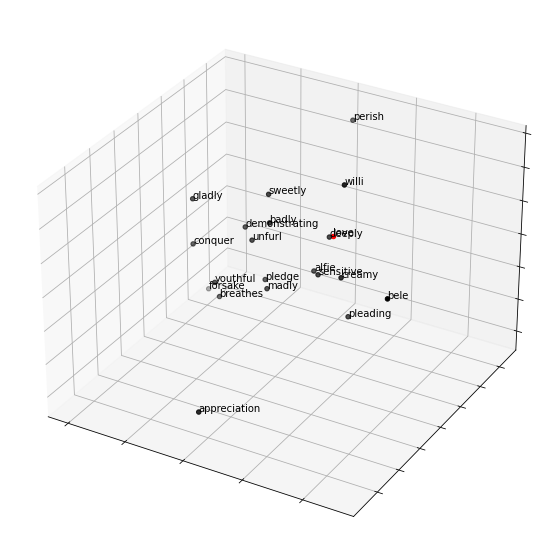

In [18]:
#plot word embeddings 

import warnings
warnings.filterwarnings('ignore')
word = "love"
fig = plt.figure(figsize=[10,10])
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 model.wv.most_similar(word, topn=20)]
X =  model.wv[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [19]:
#save index as array and reset index
wv_index=df_wv.index
#df_wv=df_wv.reset_index(drop=True)

Credits: https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

## Create feature matrix

In [20]:
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [21]:
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token=None, 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

In [22]:
#get max len sequence
max_len=max([len(list) for list in lst_text2seq])
print("Max length of sequence is: ", max_len)

Max length of sequence is:  1290


In [23]:
## padding sequence
X = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=max_len, padding="post", truncating="post")

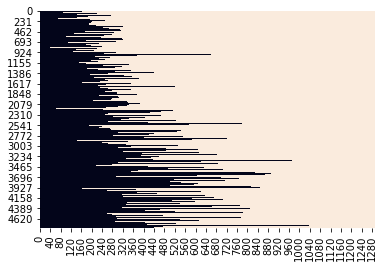

In [24]:
sns.heatmap(X==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [25]:
#no of words in embedding matrix?
df_wv.shape


(18632, 300)

In [26]:
X_df=pd.DataFrame(X)

In [27]:
#join embedding matrix with dic to be able to get word vectors by word in song
wv_df=pd.DataFrame.from_dict(dic_vocabulary, orient='index', columns=['loc']).join(df_wv)

In [28]:
wv_df=wv_df.set_index('loc')


In [29]:
wv_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
loc,,,,,,,,,,,,,,,,,,,,,
1,-0.147987,0.074612,0.052261,0.047379,0.022288,-0.068162,0.177176,0.267950,-0.177375,0.085987,...,0.068076,0.302823,0.070944,-0.173173,-0.239105,0.245255,0.190572,-0.168747,-0.080344,-0.116640
2,-0.073968,0.016434,0.120586,0.024047,-0.072568,-0.109635,0.164392,0.024587,-0.127968,-0.096691,...,0.031903,0.226809,0.059779,-0.288961,-0.094411,0.079313,0.187673,-0.073585,-0.205779,0.078755
3,-0.072928,0.220660,-0.068058,-0.050958,-0.022341,-0.108904,-0.006726,0.034973,-0.053293,-0.170799,...,-0.098284,0.089123,0.006271,0.034602,-0.208471,-0.097697,0.130751,-0.175251,0.034474,-0.154542
4,-0.117229,0.085262,0.230977,-0.152745,-0.133891,-0.258076,-0.028485,0.569459,-0.344241,0.026958,...,-0.028144,0.168748,-0.151519,-0.011959,-0.118888,0.093834,0.142272,-0.039277,0.112631,0.244770
5,-0.107298,0.190363,0.182451,0.020499,-0.070588,-0.185811,0.226441,0.021733,-0.104017,-0.376815,...,-0.012324,0.205903,-0.084269,-0.030024,-0.088087,-0.182420,0.147365,0.095007,-0.107181,0.184106


In [30]:
#get averages of word vectors by song
wv_list=[]
for a in X: #song array in X
    song_wv=[]
    for i in a: #index of word vector embeddings matrix
        if i>0:
            vec=list(wv_df.iloc[i-1]) #get word vector for word in song
            song_wv.append(vec) #append word vector to song list
            #get column averages by song 
        else:
            pass
    np_song = np.array(song_wv)
    mean_song=np.mean(np_song, axis=0)
    wv_list.append(mean_song)

In [31]:
df_wordvec=pd.DataFrame(wv_list)
df_wordvec.to_pickle("df_wordvec")

## Create neural net

In [32]:
y=pd.cut(df.Rank,bins=[0,50,100],labels=[1,0])

In [33]:
## split dataset
X_train, X_test, y_train, y_test = train_test_split(X_df,y, test_size=0.33, random_state=42)

In [34]:

embeddings=df_wv
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(max_len,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=max_len, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=max_len)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=max_len, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=max_len, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1290)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1290, 300)    5589600     input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 300, 1290)    0           embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 300, 1290)    1665390     permute[0][0]                    
______________________________________________________________________________________________

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()